In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 300

# Getting started

First generate a simulated dataset:

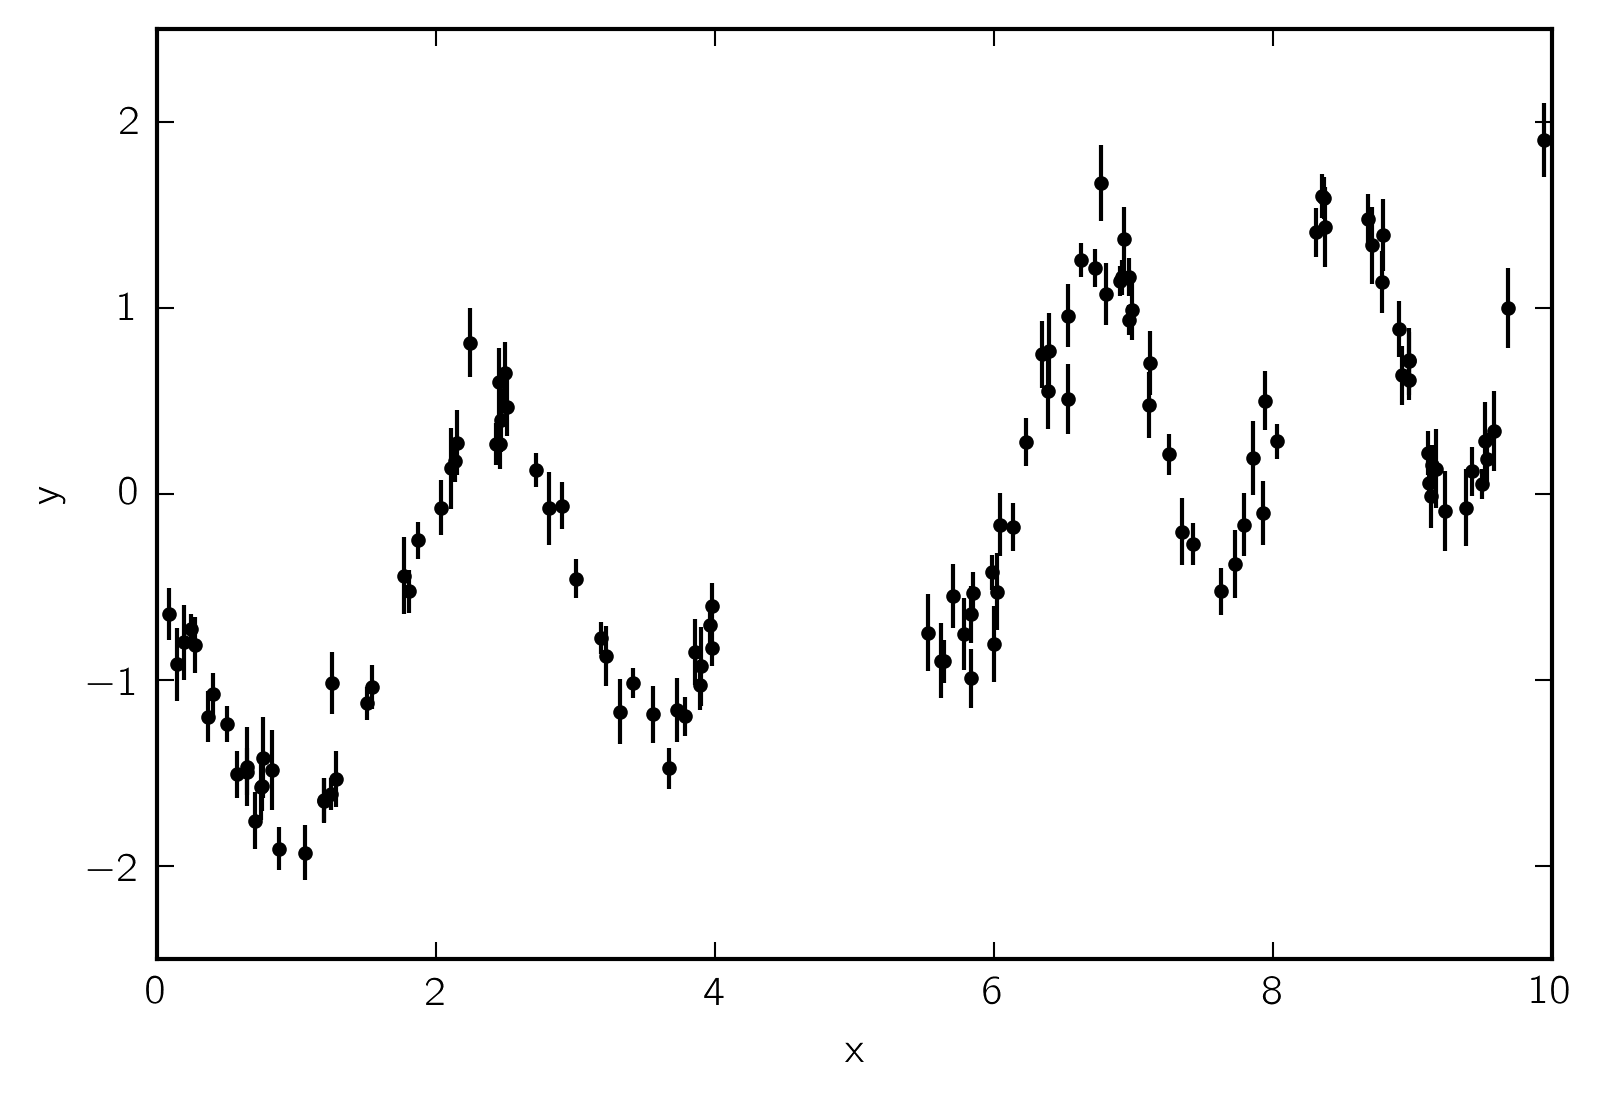

In [5]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

t = np.sort(np.append(
    np.random.uniform(0, 4.1, 57),
    np.random.uniform(5.5, 10, 68),
))  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
y = 0.2 * (t-5) + np.sin(3*t + 0.1*(t-5)**2) + yerr * np.random.randn(len(t))

plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);

Now let's fit this using `celerite`.

Initial log likelihood: -7.697249284340302


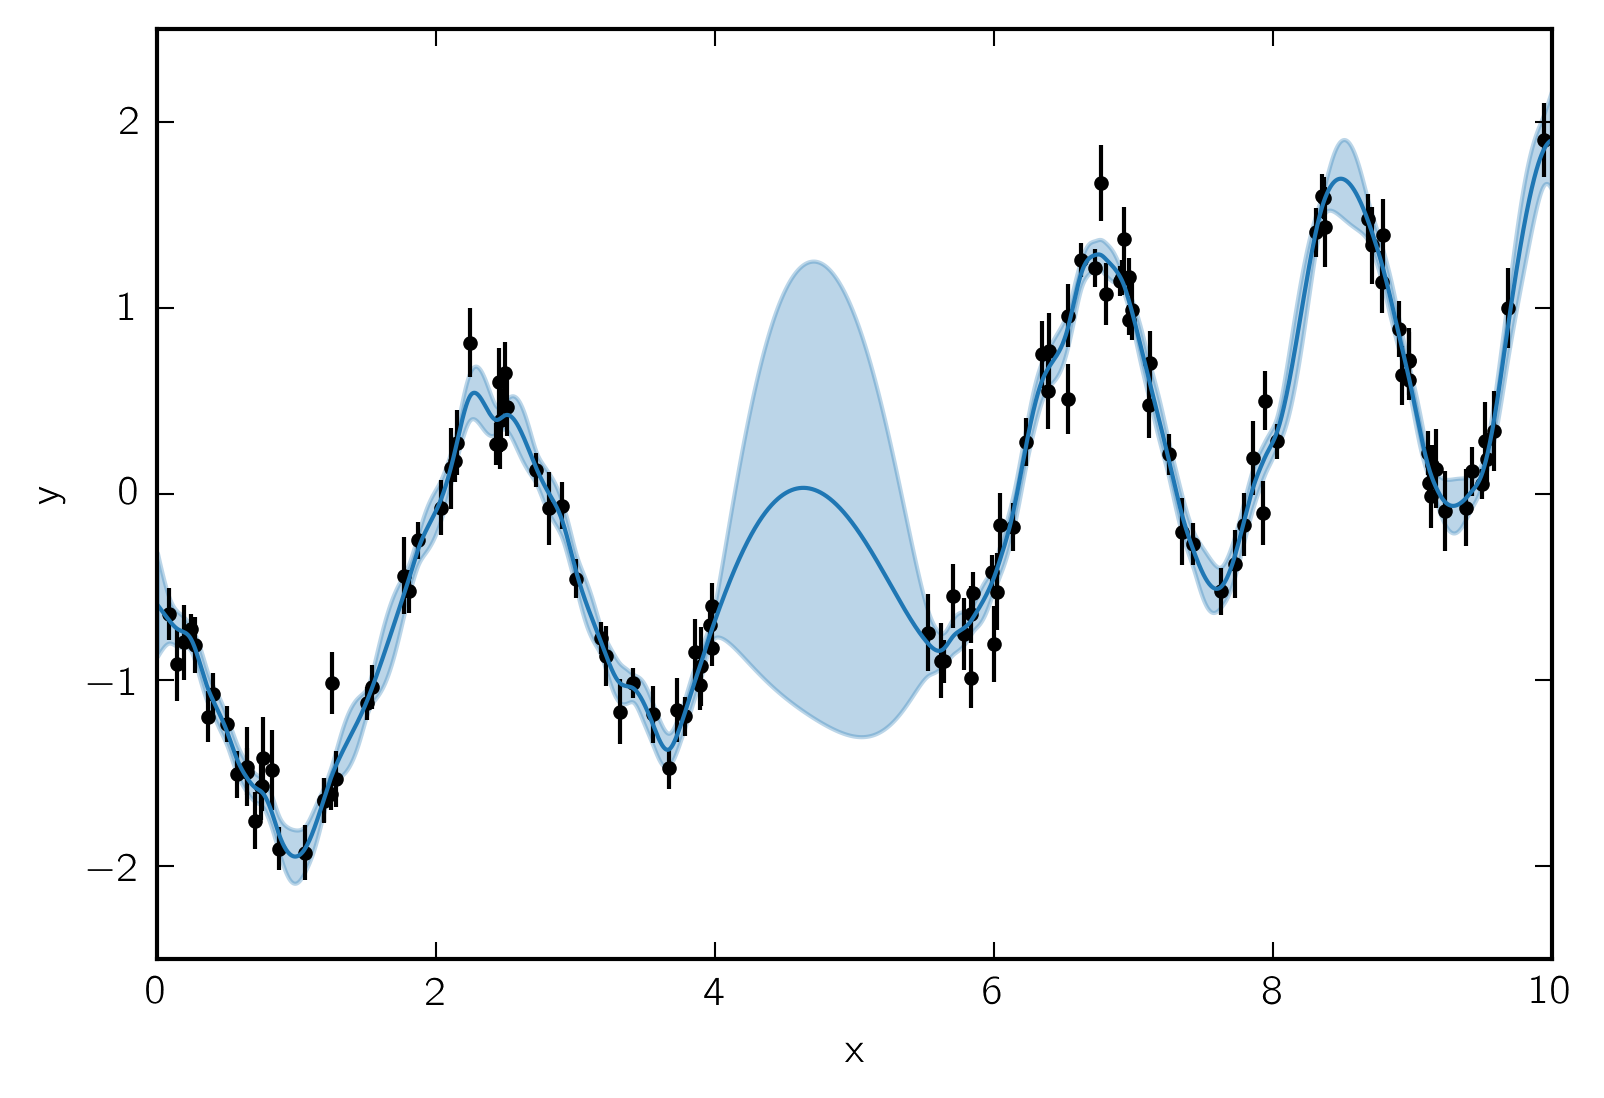

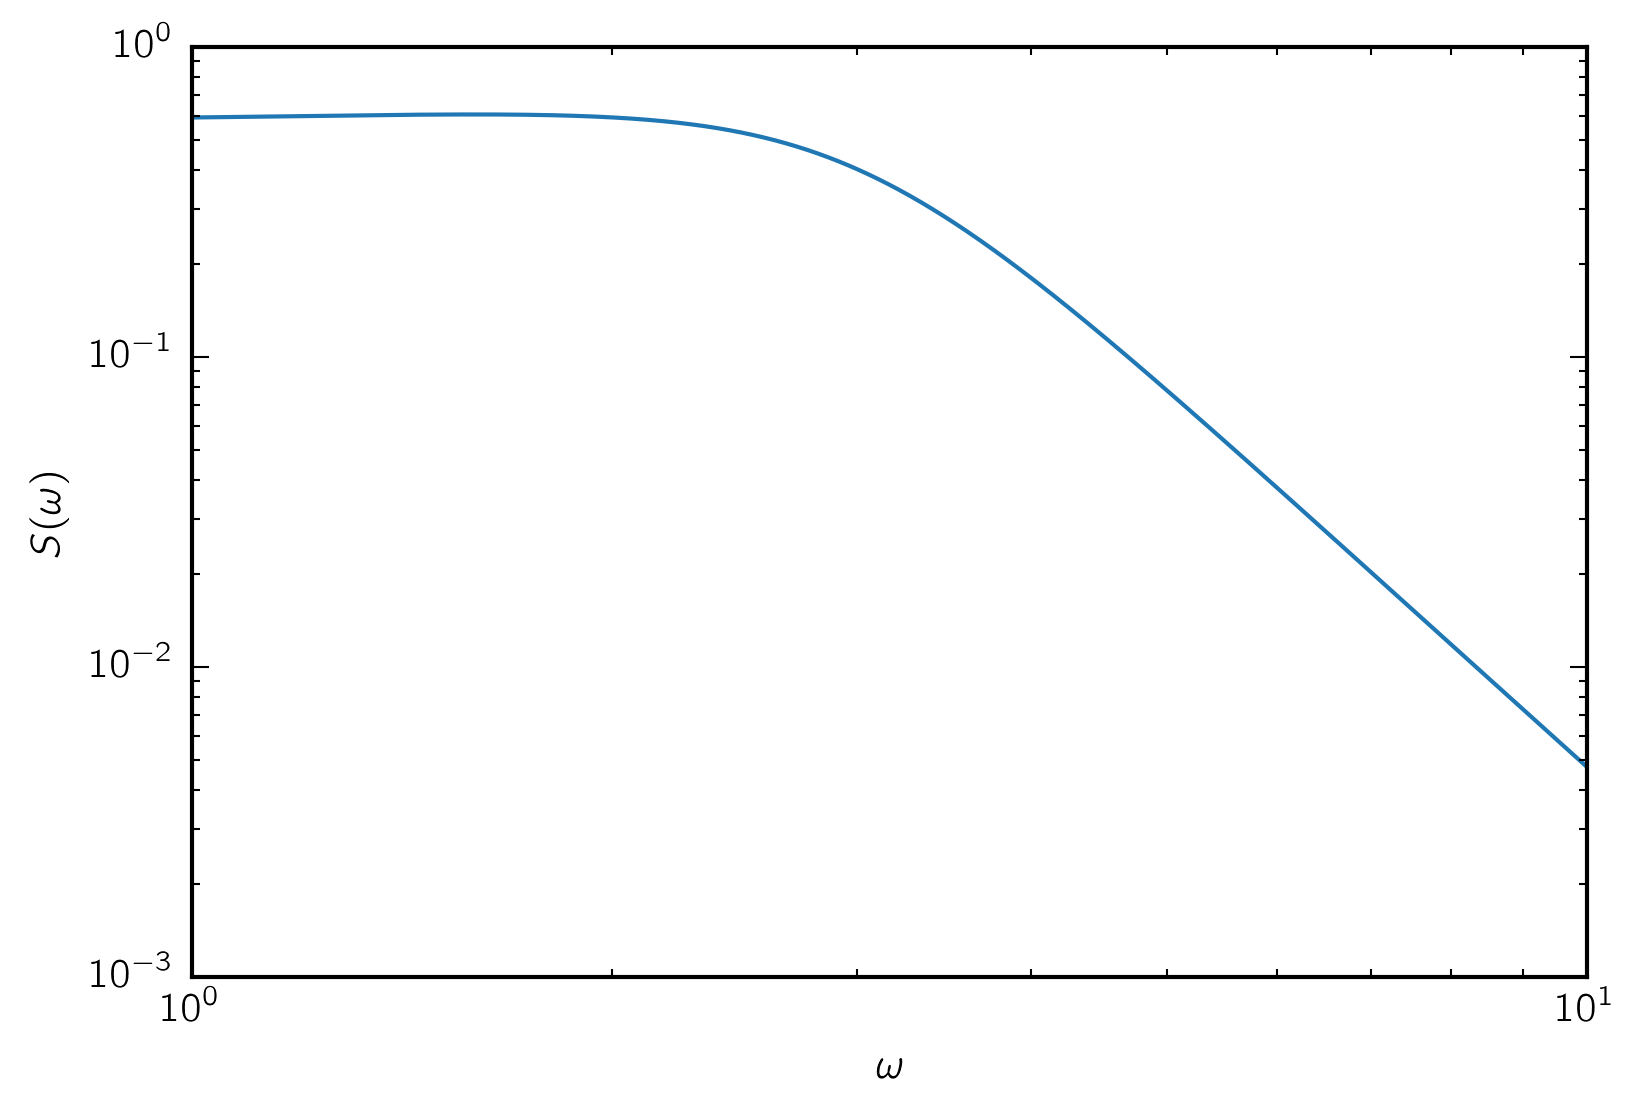

In [6]:
import celerite
from celerite import terms

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel = terms.SHOTerm(np.log(S0), np.log(Q), np.log(w0),
                       bounds=[(-15, 15), (-15, 15), (-15, 15)])

# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(np.log(S0), np.log(Q), np.log(w0),
                        bounds=[(-15, 15), (-15, 15), (-15, 15)])

gp = celerite.GP(kernel, mean=np.mean(y), fit_mean=True)
gp.compute(t, yerr)
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

x = np.linspace(0, 10, 5000)
initial_mu, initial_var = gp.predict(y, x, return_var=True)

initial_color = "#1f77b4"
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, initial_mu, color=initial_color)
plt.fill_between(x, initial_mu + np.sqrt(initial_var),
                 initial_mu - np.sqrt(initial_var),
                 color=initial_color, alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)

plt.figure()
omega = np.linspace(0.1, 10, 5000)
initial_psd = gp.kernel.get_psd(omega)
plt.plot(omega, initial_psd, color=initial_color)
plt.yscale("log")
plt.xscale("log")
plt.xlim(1, 10)
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

We can look at the parameters:

In [7]:
gp.get_parameter_dict()

OrderedDict([('mean:value', -0.13537573068686803),
             ('kernel:term[0]:log_S0', -1.2167235687061821),
             ('kernel:term[0]:log_Q', 0.0),
             ('kernel:term[0]:log_omega0', 1.0986122886681098),
             ('kernel:term[1]:log_S0', -0.87014997842620934),
             ('kernel:term[1]:log_Q', -0.34657359027997275),
             ('kernel:term[1]:log_omega0', 1.0986122886681098)])

Let's freeze the Q-factor for the non-periodic component so that we don't fit for it:

In [8]:
gp.freeze_parameter("kernel:term[1]:log_Q")
gp.get_parameter_dict()

OrderedDict([('mean:value', -0.13537573068686803),
             ('kernel:term[0]:log_S0', -1.2167235687061821),
             ('kernel:term[0]:log_Q', 0.0),
             ('kernel:term[0]:log_omega0', 1.0986122886681098),
             ('kernel:term[1]:log_S0', -0.87014997842620934),
             ('kernel:term[1]:log_omega0', 1.0986122886681098)])

Fit for the maximum likelihood parameters:

In [9]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -15.861807874981082
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.70530257e-05,  -6.25277607e-05,   4.26325641e-05,
        -1.22213351e-04,   9.09494702e-05,   1.16529009e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 329
      nit: 38
   status: 0
  success: True
        x: array([ -8.19558541e-04,  -4.15780060e+00,   2.32896004e+00,
         1.13427743e+00,   3.45053505e+00,  -2.11692490e+00])


Here are the maximum likelihood parameters:

In [10]:
gp.get_parameter_dict()

OrderedDict([('mean:value', -0.0008195585409595189),
             ('kernel:term[0]:log_S0', -4.1578005977975963),
             ('kernel:term[0]:log_Q', 2.328960041935737),
             ('kernel:term[0]:log_omega0', 1.1342774287947972),
             ('kernel:term[1]:log_S0', 3.4505350503307022),
             ('kernel:term[1]:log_omega0', -2.1169249022674594)])

And here are the predictions that the maximum likelihood model makes:

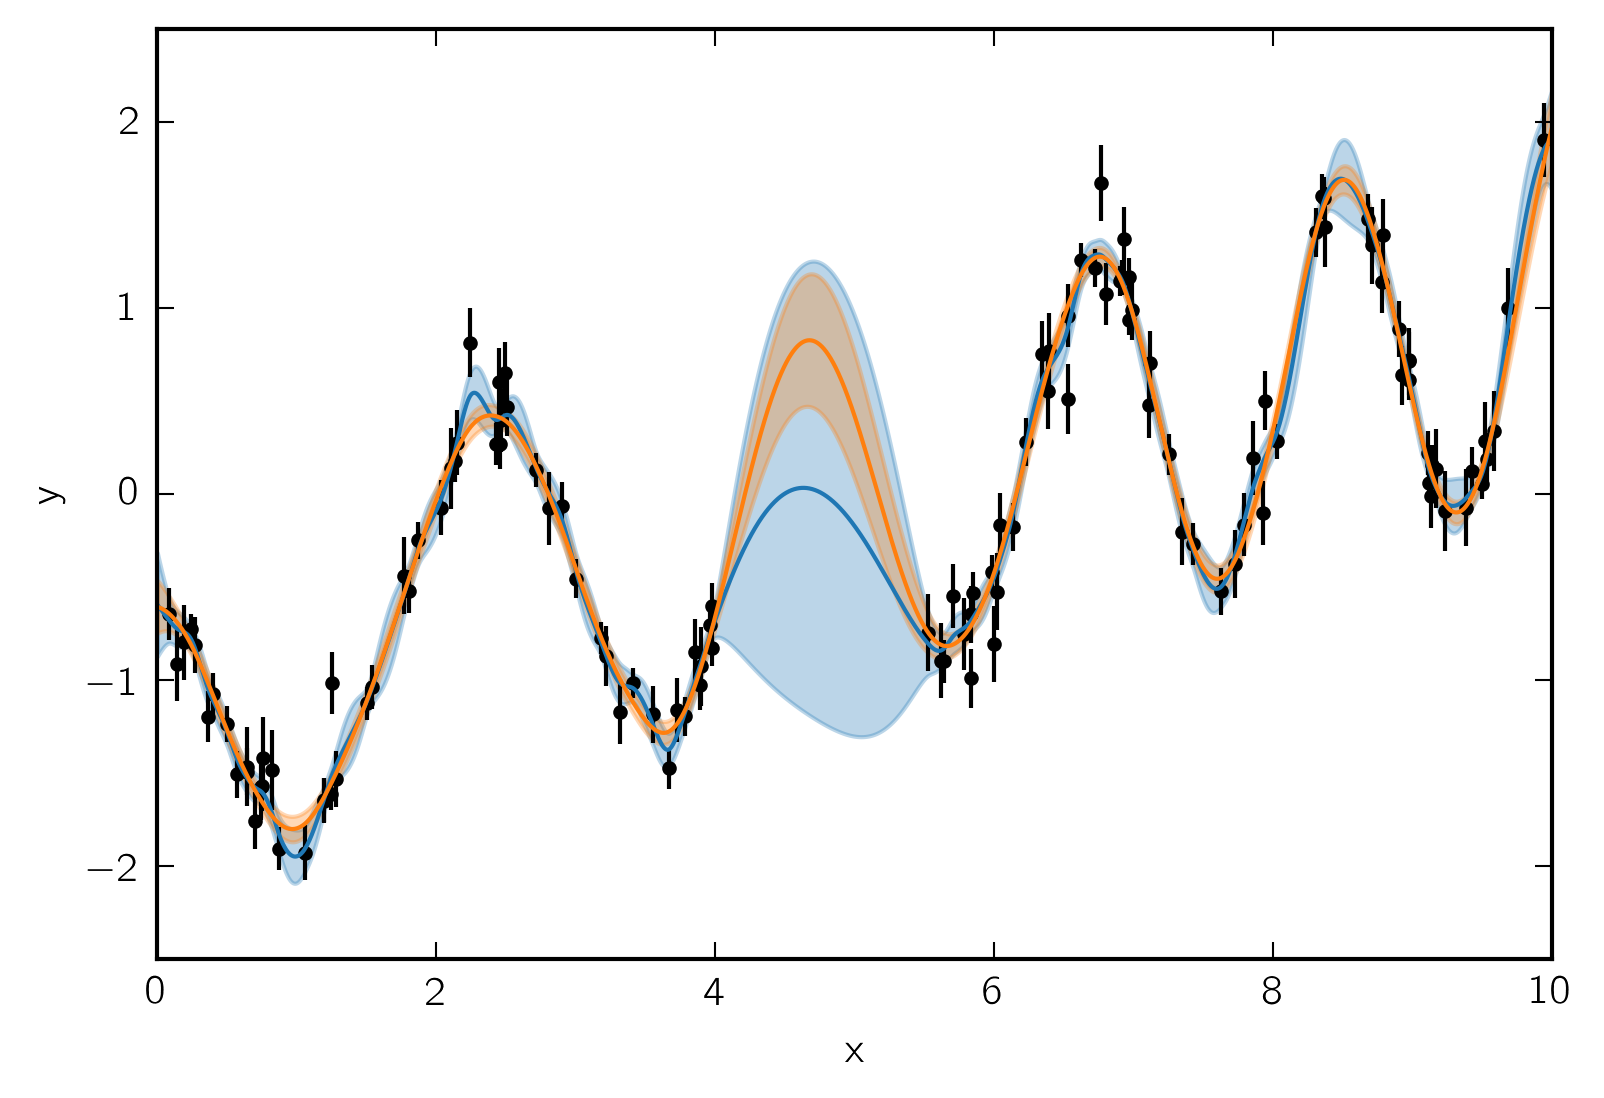

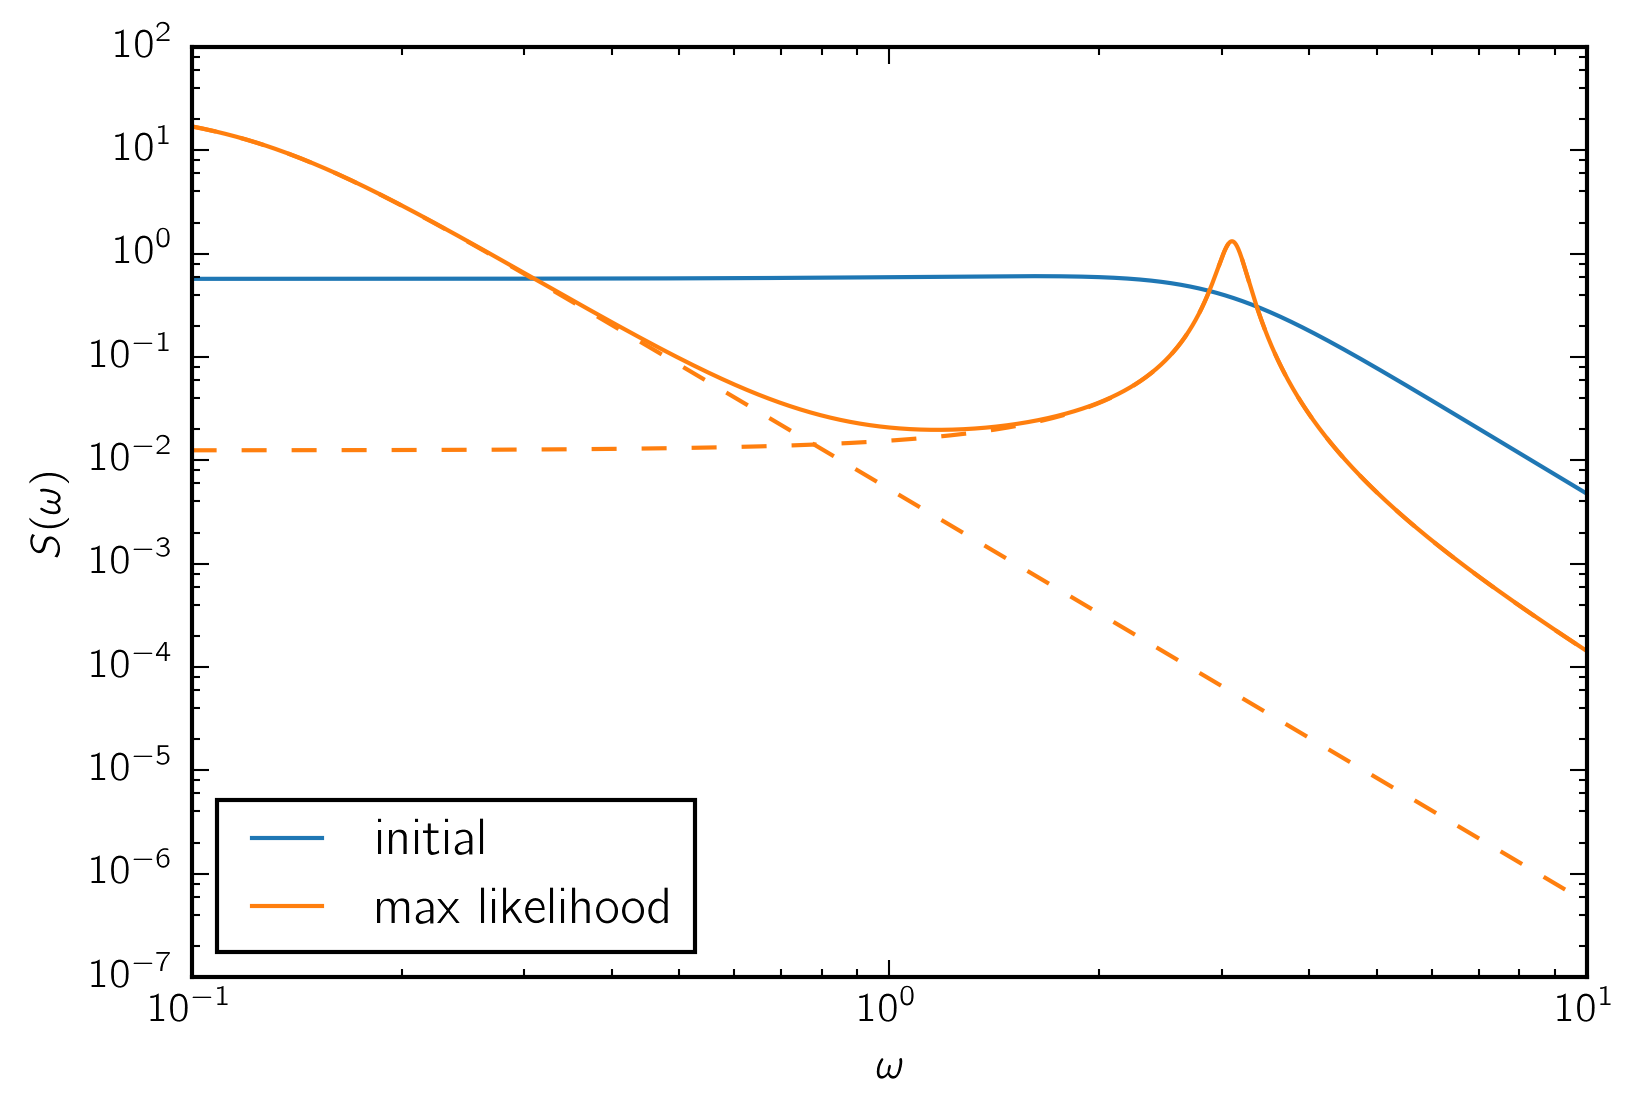

In [11]:
mu, var = gp.predict(y, x, return_var=True)

ml_color = "#ff7f0e"
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, initial_mu, color=initial_color)
plt.fill_between(x, initial_mu + np.sqrt(initial_var),
                 initial_mu - np.sqrt(initial_var),
                 color=initial_color, alpha=0.3)
plt.plot(x, mu, color=ml_color)
plt.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color=ml_color, alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)

plt.figure()
psd = gp.kernel.get_psd(omega)
plt.plot(omega, initial_psd, color=initial_color, label="initial")
plt.plot(omega, psd, color=ml_color, label="max likelihood")
plt.legend(loc=3, fontsize=12)

# Let's plot each component of the PSD:
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=ml_color)

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");